In [1]:
import sys
sys.path.insert(0, '/Users/arvinkarpiah/Desktop/Research/Madagascar/RSFSRC/lib/python3.11/site-packages')
from scipy.signal import butter, filtfilt
import m8r
import numpy as np
import pandas as pd
import tensorflow as tf
import copy, time
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import load_model
from functions import normalize 
from functions2 import readrsffiles, readrsfile
from functionsAK import read_bin
from functionsAK import normalize_by_column
# from functionsAK import sgy_to_bin
from functionsAK import gen_features
# import segyio
# from functionsAK import read_segy_info
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as skm

In [2]:
# Load datas
seis_das = read_bin('shotoff_9_das_upg.bin', 501, 1273)
seis_geo = read_bin('shotoff_9_geo_upg.bin', 550, 24)

geophone_geometry = np.loadtxt('geogeom.txt')


# Get dimensions of data

nchan_das = seis_das.shape[0]
nsamp_das = seis_das.shape[1]
nchan_geo = seis_geo.shape[0]
nsamp_geo = seis_geo.shape[1]

print(nchan_das,nsamp_das)

# Sampling times in seconds
dt_das = 2e-3;
dt_geo = 1e-3;

# Sampling distance in m
dz_das = np.arange(0, nchan_das * 0.25 + 0.0001, 0.25)[:nchan_das]
dz_geo = geophone_geometry[0:24, 6] / 10

# Generate time vector
timeDAS = np.arange(0, nsamp_das) * dt_das
timeGeophone = np.arange(0, nsamp_geo) * dt_geo

# Rotate the seismic image 90 degrees clockwise
seis_das_rotated = np.rot90(seis_das, k=-1)
seis_das_rotated = np.flip(seis_das_rotated,1)
seis_geo_rotated = np.rot90(seis_geo, k=-1)
seis_geo_rotated = np.flip(seis_geo_rotated,1)

# # Display the rotated images
# plt.figure(figsize=(10,5)) 
# plt.subplot(1,2,1)
# plt.xlabel('Channels')
# plt.ylabel('Time(s)')
# plt.title('DAS')
# plt.imshow(seis_das_rotated, cmap='gray', vmin=np.percentile(seis_das_rotated, 5), vmax=np.percentile(seis_das_rotated, 95), aspect='auto', extent=[dz_das[0], dz_das[-1], timeDAS[-1], timeDAS[0]])
# plt.tight_layout()  # Add this line to adjust the layout
# plt.ylim(timeGeophone[-1], 0)  # Set y-axis limits

# plt.subplot(1,2,2)
# plt.xlabel('Depth(m)')
# plt.ylabel('Time(s)')
# plt.title('Geophone')
# plt.imshow(seis_geo_rotated, cmap='gray', 
#            vmin=np.percentile(seis_geo_rotated, 5), 
#            vmax=np.percentile(seis_geo_rotated, 95),
#            aspect='auto',
#            extent=[dz_geo[0], dz_geo[-1], timeGeophone[-1], timeGeophone[0]])


# plt.tight_layout()  # Add this line to adjust the layout
# plt.ylim(timeGeophone[-1], 0)  # Set y-axis limits


1273 501


In [3]:
seis_das_rotated_norm = normalize_by_column(seis_das_rotated)
seis_geo_rotated_norm = normalize_by_column(seis_geo_rotated)

print(np.max(seis_das_rotated_norm))
print(np.min(seis_das_rotated_norm))
print(np.max(seis_geo_rotated_norm))
print(np.min(seis_geo_rotated_norm))

1.0
-2.552005
1.0
-1.8318057


In [4]:
# Generate training data from geophone data

X = seis_das_rotated_norm
Y = dz_das

print(X.shape[1])

# For each trace, extract features 

X_feature_eng= gen_features(X)

print(X_feature_eng.shape)
    

1273


ValueError: Shape of passed values is (1273, 2), indices imply (1273, 3)

In [ ]:
print(X.shape)
print(Y.shape)
print(X_feature_eng.shape)


(501, 1273)
(1273,)
(1273, 3)


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming you have your dataset X (features) and y (labels)
# Let's say X is your 24 by 4 dataset and y is the corresponding labels

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_feature_eng, Y, test_size=0.2, random_state=42)

# Creating a Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 4782.6157033800055


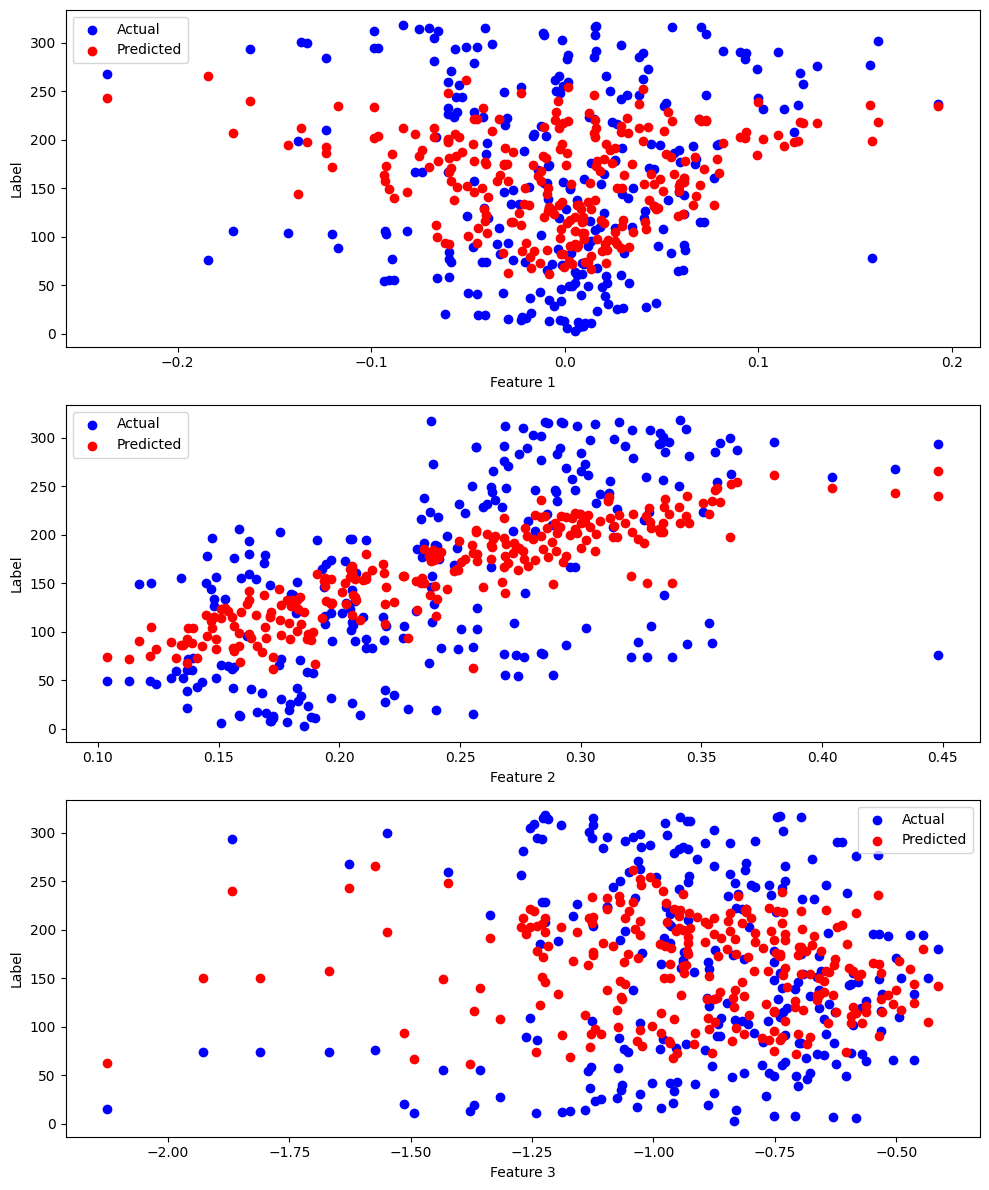

In [10]:
# Visualization

import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined

# Convert X_test to a NumPy array if it's a DataFrame
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

num_features = X_test.shape[1]

fig, axs = plt.subplots(num_features, 1, figsize=(10, num_features*4))

for i in range(num_features):
    axs[i].scatter(X_test[:, i], y_test, color='blue', label='Actual')
    axs[i].scatter(X_test[:, i], y_pred, color='red', label='Predicted')
    axs[i].set_xlabel(f'Feature {i+1}')
    axs[i].set_ylabel('Label')
    axs[i].legend()

plt.tight_layout()
plt.show()



(0.549, 0.0)

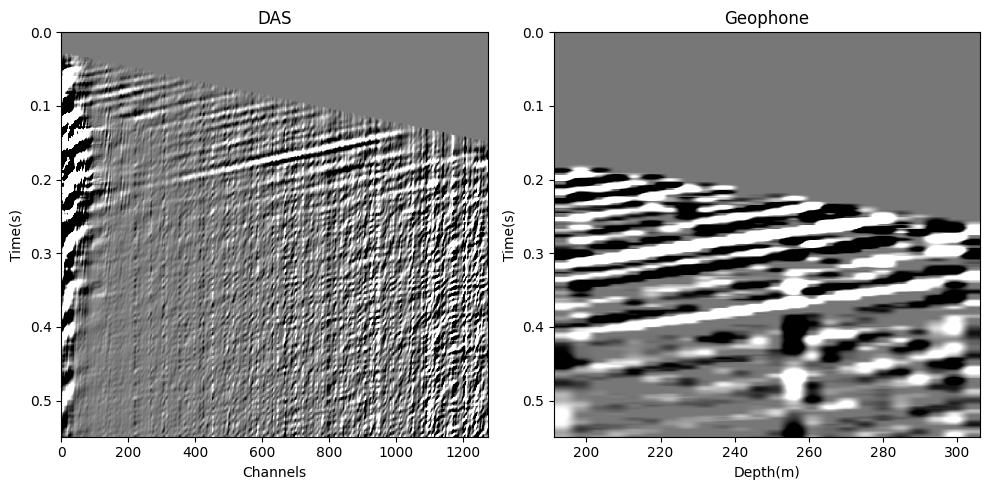

In [8]:
# #Convert geophone signals from m/ms to m/s for consistent comparison
seis_geo_rotated = seis_geo_rotated *1000

# # Convert DAS signals (strain rate) to geophone (particle velocity) using Daley 2016 approach

seis_DAS_converted = (seis_das_rotated*2880)/10

# Display the rotated images
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1)
plt.xlabel('Channels')
plt.ylabel('Time(s)')
plt.title('DAS')
plt.imshow(seis_DAS_converted, cmap='gray', vmin=np.percentile(seis_DAS_converted, 5), vmax=np.percentile(seis_DAS_converted, 95), aspect='auto', extent=[0, nchan_das, timeDAS[-1], 0])
plt.tight_layout()  # Add this line to adjust the layout
plt.ylim(timeGeophone[-1], 0)  # Set y-axis limits

plt.subplot(1,2,2)
plt.xlabel('Depth(m)')
plt.ylabel('Time(s)')
plt.title('Geophone')
plt.imshow(seis_geo_rotated, cmap='gray', 
           vmin=np.percentile(seis_geo_rotated, 5), 
           vmax=np.percentile(seis_geo_rotated, 95),
           aspect='auto',
           extent=[dz_geo[0], dz_geo[-1], timeDAS[-1], timeDAS[0]])


plt.tight_layout()  # Add this line to adjust the layout
plt.ylim(timeGeophone[-1], 0)  # Set y-axis limits



In [9]:
# Check stats
print(np.max(seis_geo_rotated))
print(np.min(seis_geo_rotated))
print(np.max(seis_DAS_converted))
print(np.min(seis_DAS_converted))


716.0858
-401.691
2152.7537
-1759.3278


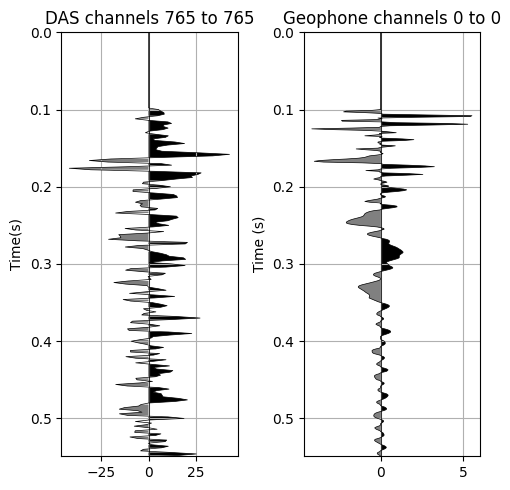

In [10]:

seismic_data_das = seis_DAS_converted
# Define the subset of columns (traces) you want to display
start_channel = 765  # Index of the first channel (column)
end_channel = 765  # Index of the last channel (column)

# Extract the subset of columns (traces)
subset_traces = seismic_data_das[:, start_channel:end_channel+1]

# Plotting
plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)

# Loop through each trace and plot it as a wiggle plot
for i, trace in enumerate(subset_traces.T):  # Transpose to loop through columns (traces)
    #trace_amp = trace / np.max(np.abs(trace))  # Normalize trace amplitudes for plotting
    plt.plot(trace + i, timeDAS, color='black', linewidth=0.5)  # Plot the trace outline
    plt.fill_betweenx(timeDAS, i, trace + i, where=(trace + i) > i, color='black', linewidth=0)  # Fill positive amplitudes
    plt.fill_betweenx(timeDAS, i, trace + i, where=(trace + i) < i, color='gray', linewidth=0)  # Fill negative amplitudes
    plt.plot([i, i], [min(timeDAS), max(timeDAS)], color='black', linewidth=0.5)  # Outline for both black and gray areas


plt.ylabel('Time(s)')
plt.title(f'DAS channels {start_channel} to {end_channel}')
plt.gca().invert_yaxis()  # Invert y-axis to display time increasing downward
plt.ylim(timeGeophone[-1], 0)  # Set y-axis limits
plt.grid(True)

# Geophone
seismic_data_geo = normalize(seis_geo_rotated)  # 100 traces, 1000 samples per trace

# Define the subset of columns (traces) you want to display
start_channel = 0  # Index of the first channel (column)
end_channel = 0  # Index of the last channel (column)

# Extract the subset of columns (traces)
subset_traces = seismic_data_geo[:, start_channel:end_channel+1]

plt.subplot(1, 2, 2)
# Loop through each trace and plot it as a wiggle plot
for i, trace in enumerate(subset_traces.T):  # Transpose to loop through columns (traces)
    #trace_amp = trace / np.max(np.abs(trace))  # Normalize trace amplitudes for plotting
    plt.plot(trace + i, timeGeophone, color='black', linewidth=0.5)  # Plot the trace outline
    plt.fill_betweenx(timeGeophone, i, trace + i, where=(trace + i) > i, color='black', linewidth=0)  # Fill positive amplitudes
    plt.fill_betweenx(timeGeophone, i, trace + i, where=(trace + i) < i, color='gray', linewidth=0)  # Fill negative amplitudes
    plt.plot([i, i], [min(timeGeophone), max(timeGeophone)], color='black', linewidth=0.5)  # Outline for both black and gray areas

plt.ylabel('Time (s)')
plt.title(f'Geophone channels {start_channel} to {end_channel}')
plt.gca().invert_yaxis()  # Invert y-axis to display time increasing downward
plt.grid(True)

plt.tight_layout()
plt.ylim(timeGeophone[-1], 0)  # Set y-axis limits
plt.show()
 

In [11]:
print(np.max(seis_geo_rotated))
print(np.min(seis_geo_rotated))
print(np.max(seis_DAS_converted))
print(np.min(seis_DAS_converted))

716.0858
-401.691
2152.7537
-1759.3278


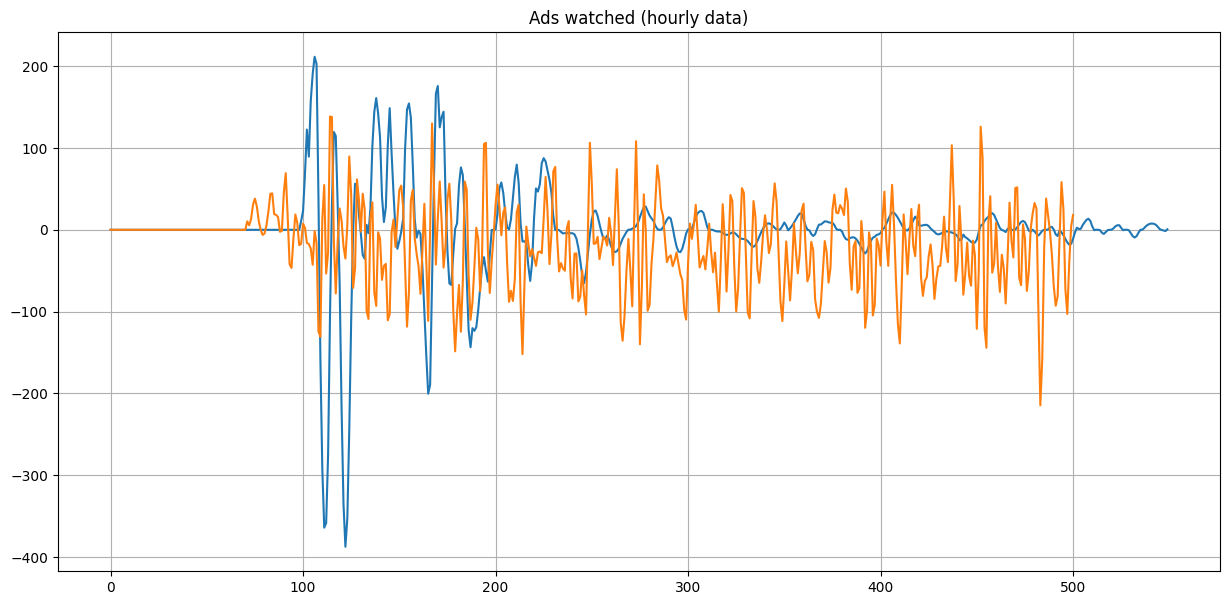

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(seis_geo_rotated[:,1])
plt.plot(seis_DAS_converted[:,1200])
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [13]:
print(np.max(seis_geo_rotated))
print(np.min(seis_geo_rotated))
print(np.max(seis_DAS_converted))
print(np.min(seis_DAS_converted))
print(np.max(seis_DAS_converted[:,1200]))

716.0858
-401.691
2152.7537
-1759.3278
138.51842


In [14]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from functionsAK import plotMovingAverage

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
plotMovingAverage(seis_DAS_converted, 4)

AttributeError: 'numpy.ndarray' object has no attribute 'rolling'